In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
import numpy as np
from scipy.stats import spearmanr

def KGE(y_true, y_pred):  # improved 2012
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    alpha = (np.std(y_pred)/np.mean(y_pred)) / (np.std(y_true)/np.mean(y_true))
    beta = np.mean(y_pred) / np.mean(y_true)
    return 1 - np.sqrt((correlation - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)


# 定义计算NSE的函数
def NSE(observed, simulated):
    return 1 - np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2)

# 定义计算rRMSE的函数
def nRMSE(observed, simulated):
    rmse = np.sqrt(mean_squared_error(observed, simulated))
    return rmse / np.mean(observed)

# 定义计算CC的函数
def CC(observed, simulated):
    return pearsonr(observed, simulated)[0]  # 使用Spearman相关系数作为CC


df = pd.read_csv('../3-process/5.q_kge_med_modified_q50_iqr_node_1.5_noqa_VersionD.csv')

# 统计每个 stationid 出现的次数
station_counts = df['stationid'].value_counts()
# 获取出现次数超过 30 的 stationid 列表
valid_stationids = station_counts[station_counts > 30].index
# 从 df 中筛选出这些 stationid 的所有行
df = df[df['stationid'].isin(valid_stationids)].copy()


stationids = df['stationid'].unique()
valid = []

for s in stationids:
    df_station = df[df['stationid']==s]
    observed = df_station['qobs']
    simulated = df_station['Q_est']
    cc = CC(observed, simulated)
    nrmse = nRMSE(observed, simulated)
    kge = KGE(observed, simulated)
    nse = NSE(observed, simulated)
    pbias = (simulated.mean() / observed.mean() - 1) 
    rv    = simulated.std() / simulated.mean()/ (observed.std() / observed.mean())
    valid.append({'stationid': s, 'KGE': kge, 'NSE': nse,'NRMSE': nrmse,'CC': cc, 'pBIAS': pbias, 'RV': rv})


valid_df = pd.DataFrame(valid)
valid_df.to_csv('2.validation_SWAP_modified_q50.csv')

/tmp/ipykernel_29738/2987067837.py:28: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return pearsonr(observed, simulated)[0]  # 使用Spearman相关系数作为CC
/tmp/ipykernel_29738/2987067837.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  return rmse / np.mean(observed)
/home/xj/anaconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/xj/anaconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/tmp/ipykernel_29738/2987067837.py:12: RuntimeWarning: invalid value encountered in scalar divide
  alpha = (np.std(y_pred)/np.mean(y_pred)) / (np.std(y_true)/np.mean(y_true))
/tmp/ipykernel_29738/2987067837.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  beta = np.mean(y_pred) / np.mean(y_true)
/tmp/ipykernel

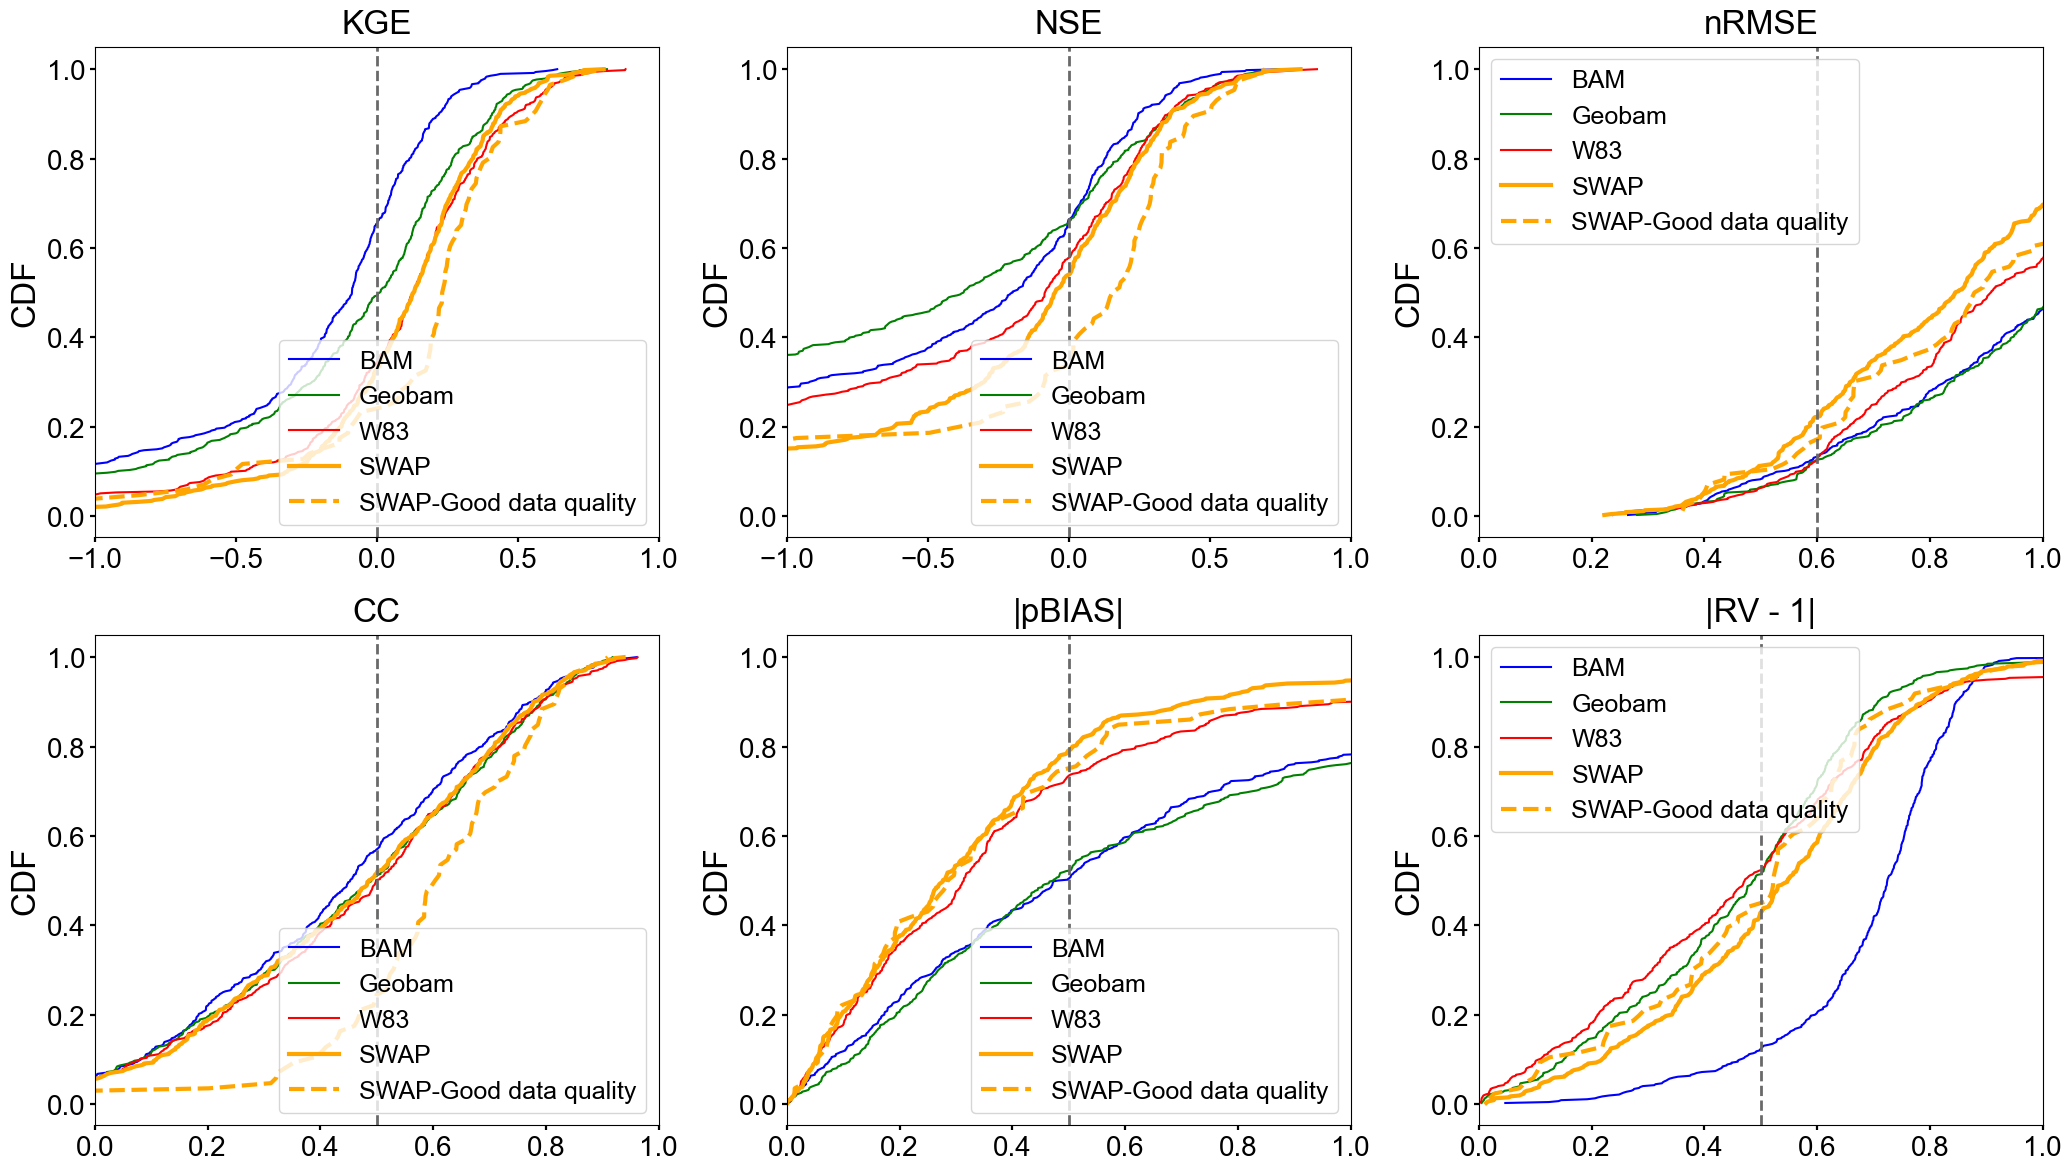

In [2]:
swap_df = pd.read_csv('2.validation_SWAP_modified_q50.csv')
swap_df.rename(columns={'PB': 'pBIAS'}, inplace=True)
# # 统计每个 stationid 出现的次数
# station_counts = swap_df['stationid'].value_counts()
# # 获取出现次数超过 30 的 stationid 列表
# valid_stationids = station_counts[station_counts > 30].index
# # 从 df 中筛选出这些 stationid 的所有行
# df_w83 = swap_df[swap_df['stationid'].isin(valid_stationids)].copy()


bam_df = pd.read_csv('bamgeobam/statistics_all_bam.csv')
bam_df.rename(columns={'PB': 'pBIAS'}, inplace=True)
bam_df['pBIAS'] = bam_df['pBIAS']/100.0
bam_df = bam_df[bam_df['stationid'].isin(swap_df['stationid'])]

geobam_df = pd.read_csv('bamgeobam/statistics_all_geobam.csv')
geobam_df.rename(columns={'PB': 'pBIAS'}, inplace=True)
geobam_df['pBIAS'] = geobam_df['pBIAS']/100.0
geobam_df = geobam_df[geobam_df['stationid'].isin(swap_df['stationid'])]

w83_df = pd.read_csv('1.validation_W83_q50.csv')
w83_df.rename(columns={'PB': 'pBIAS'}, inplace=True)
w83_df = w83_df[w83_df['stationid'].isin(swap_df['stationid'])]

columns = ['KGE', 'NSE', 'NRMSE', 'CC', 'pBIAS', 'RV']
# 删除包含缺失值的行
swap_df.dropna(subset=columns, inplace=True)
bam_df.dropna(subset=columns, inplace=True)
geobam_df.dropna(subset=columns, inplace=True)
w83_df.dropna(subset=columns, inplace=True)


df_metrics = pd.read_csv('4.swot_hypso_metrics.csv')[['stationid','nrmse']]
swap_df_good = swap_df.merge(df_metrics,on='stationid',how='inner').drop_duplicates()

df_q_all = pd.read_csv('../3-process/5.q_kge_med_modified_q50_iqr_node_1.5_noqa_VersionD.csv')
stations = swap_df_good['stationid'].unique()

# 创建新列（初始化为NaN）
swap_df_good['corr_val'] = np.nan
swap_df_good['nrmse'] = np.nan

for s in stations:
    df_q = df_q_all[df_q_all['stationid']==s]
    df_q = df_q.sort_values('date')
    corr_val = spearmanr(df_q['width'], df_q['qobs']).correlation
    nrmse = df_metrics.loc[df_metrics['stationid'] == s, 'nrmse'].iloc[0]
    swap_df_good.loc[swap_df_good['stationid'] == s, 'corr_wq_qa'] = corr_val
    swap_df_good.loc[swap_df_good['stationid'] == s, 'nrmse_fitting_qa'] = nrmse


swap_df_good = swap_df_good[(swap_df_good['corr_wq_qa'] > 0.5) & (swap_df_good['nrmse_fitting_qa'] < 0.5)]    


# Define x-axis ranges for each subplot
x_axis_ranges = {
    'KGE': [-1, 1],
    'NSE': [-1, 1],
    'NRMSE': [0, 1],
    'CC': [0, 1],
    'pBIAS': [0, 1],
    'RV': [0, 1]
}

# 设置更大的全局字体和图像尺寸
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlepad'] = 10
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['xtick.major.width'] = 1.6
plt.rcParams['ytick.major.width'] = 1.6

# 过滤掉原始 'rv' 指标，只保留我们想画的列
columns = [col for col in columns if not col.lower().endswith('_rv')]

# 创建画布（假设有 6 个指标）
fig, axes = plt.subplots(2, 3, figsize=(21, 12))
axes = axes.flatten()

# 定义颜色 
colors = {
    'BAM': 'blue',
    'Geobam': 'green',
    'W83': 'red',
    'SWAP': 'orange'
}

# # 定义 CDF 绘图函数
# def plot_cdf(data, ax, label, x_range=None, color=None, linewidth=None):
#     sorted_data = sorted(data)
#     cdf = [i / len(sorted_data) for i in range(1, len(sorted_data) + 1)]
#     ax.plot(sorted_data, cdf, label=label, color=color, linewidth=linewidth)
#     if x_range:
#         ax.set_xlim(x_range)
#     ax.set_ylabel('CDF')
#     # ax.grid(True)

def plot_cdf(data, ax, label, x_range=None, **kwargs):  # 添加 **kwargs 接收额外参数
    sorted_data = sorted(data)
    cdf = [i / len(sorted_data) for i in range(1, len(sorted_data) + 1)]
    ax.plot(sorted_data, cdf, label=label, **kwargs)  # 传递 kwargs 到 plot 函数
    if x_range:
        ax.set_xlim(x_range)
    ax.set_ylabel('CDF')

# 绘图
for i, col in enumerate(columns):
    ax = axes[i]
    
    # 指标处理
    if 'rv' in col.lower():
        transform = lambda x: abs(x - 1)
        title = '|RV - 1|'
    elif 'pbias' in col.lower():
        transform = lambda x: abs(x)
        title = '|pBIAS|'
    else:
        transform = lambda x: x
        title = col.replace('NRMSE', 'nRMSE').replace('nrmse', 'nRMSE')

    # 依次绘制不同方法的 CDF
    plot_cdf(transform(bam_df[col].dropna()), ax, 'BAM', x_range=x_axis_ranges[col], color=colors['BAM'], linewidth=1.5)
    plot_cdf(transform(geobam_df[col].dropna()), ax, 'Geobam', x_range=x_axis_ranges[col], color=colors['Geobam'], linewidth=1.5)
    plot_cdf(transform(w83_df[col].dropna()), ax, 'W83', x_range=x_axis_ranges[col], color=colors['W83'], linewidth=1.5)
    plot_cdf(transform(swap_df[col].dropna()), ax, 'SWAP', x_range=x_axis_ranges[col], color=colors['SWAP'], linewidth=3)
    plot_cdf(transform(swap_df_good[col].dropna()), ax, 'SWAP-Good data quality', x_range=x_axis_ranges[col], color=colors['SWAP'], linewidth=3,linestyle='--')

    ax.set_title(title)
    
    # 添加竖线
    metric = col.lower()
    if 'kge' in metric or 'nse' in metric:
        ax.axvline(x=0, color='dimgray', linestyle='--', linewidth=2)
    elif 'cc' in metric or 'pbias' in metric or 'rv' in metric:
        ax.axvline(x=0.5, color='dimgray', linestyle='--', linewidth=2)
    elif 'nrmse' in metric:
        ax.axvline(x=0.6, color='dimgray', linestyle='--', linewidth=2)

    ax.legend(fontsize=18)


# 自动调整子图间距
plt.tight_layout()

# 保存并展示
plt.savefig('Fig10.png', dpi=500)
plt.show()

In [3]:
def compute_stats(df, name):
    total = len(df)
    results = {
        'method': name,
        'KGE>0': (df['KGE'] > 0).sum() / total,
        'NSE>0': (df['NSE'] > 0).sum() / total,
        '|pBIAS|<0.5': (df['pBIAS'].abs() < 0.5).sum() / total,
        '|RV-1|<0.5': ((df['RV'] - 1).abs() < 0.5).sum() / total,
        'NRMSE<0.6': (df['NRMSE'] < 0.6).sum() / total,
        'CC>0.5': (df['CC'] > 0.5).sum() / total,
        'NRMSE_median': df['NRMSE'].median(),
        'NRMSE_mean': df['NRMSE'].mean(),
    }
    return results

# 对每个模型分别统计
results = []
results.append(compute_stats(swap_df, 'SWAP'))
results.append(compute_stats(bam_df, 'BAM'))
results.append(compute_stats(geobam_df, 'geoBAM'))
results.append(compute_stats(w83_df, 'W83'))
results.append(compute_stats(swap_df_good,'swap_good'))

# 转为 DataFrame 展示
import pandas as pd
summary_df = pd.DataFrame(results)
pd.set_option('display.float_format', '{:.2%}'.format)  # 百分比格式显示
print(summary_df)


      method  KGE>0  NSE>0  |pBIAS|<0.5  |RV-1|<0.5  NRMSE<0.6  CC>0.5  \
0       SWAP 67.16% 46.11%       79.16%      42.74%     22.11%  48.42%   
1        BAM 34.66% 33.61%       50.42%      12.18%     13.24%  43.07%   
2     geoBAM 50.84% 34.24%       52.10%      51.26%     12.39%  49.16%   
3        W83 65.89% 42.32%       73.47%      52.21%     12.42%  49.89%   
4  swap_good 76.74% 67.44%       74.42%      44.19%     16.28%  75.58%   

   NRMSE_median  NRMSE_mean  
0        84.57%     226.25%  
1       104.25%     444.15%  
2       104.56%     491.63%  
3        90.89%     260.86%  
4        88.65%     103.96%  


In [4]:
print(swap_df['stationid'].nunique())

475


In [5]:
print(swap_df.columns)
print(bam_df.columns)
print(w83_df.columns)
print(swap_df_good.columns)
print(geobam_df.columns)

Index(['Unnamed: 0', 'stationid', 'KGE', 'NSE', 'NRMSE', 'CC', 'pBIAS', 'RV'], dtype='object')
Index(['pfaf', 'stationid', 'CC', 'BR', 'RV', 'pBIAS', 'NRMSE', 'NSE', 'KGE',
       'nn'],
      dtype='object')
Index(['Unnamed: 0', 'stationid', 'KGE', 'NSE', 'NRMSE', 'CC', 'pBIAS', 'RV'], dtype='object')
Index(['Unnamed: 0', 'stationid', 'KGE', 'NSE', 'NRMSE', 'CC', 'pBIAS', 'RV',
       'nrmse', 'corr_val', 'corr_wq_qa', 'nrmse_fitting_qa'],
      dtype='object')
Index(['pfaf', 'stationid', 'CC', 'BR', 'RV', 'pBIAS', 'NRMSE', 'NSE', 'KGE',
       'nn'],
      dtype='object')


In [8]:
import pandas as pd
import numpy as np

# 定义评价指标的优劣方向
# True表示越大越好，False表示越小越好
metrics_direction = {
    'KGE': True,
    'NSE': True,
    'CC': True,
    'RV': True,
    'NRMSE': False,
    'pBIAS': False  # 比较绝对值
}

def compare_performance(df1, df2, name1, name2):
    """
    比较两个数据框的性能
    df1: 第一个数据框
    df2: 第二个数据框
    name1: 第一个方法名称
    name2: 第二个方法名称
    """
    # 找到共同站点
    common_stations = set(df1['stationid']) & set(df2['stationid'])
    print(f"\n{'='*80}")
    print(f"{name1} vs {name2} Performance Comparison")
    print(f"{'='*80}")
    print(f"共同站点数: {len(common_stations)}")
    
    # 筛选共同站点
    df1_common = df1[df1['stationid'].isin(common_stations)].set_index('stationid')
    df2_common = df2[df2['stationid'].isin(common_stations)].set_index('stationid')
    
    # 确保索引排序一致
    df1_common = df1_common.sort_index()
    df2_common = df2_common.sort_index()
    
    results = {}
    
    print(f"\n{'指标':<10} {name1+'优':<15} {name2+'优':<15} {'相等':<10} {name1+'优占比':<15}")
    print("-"*80)
    
    for metric in ['KGE', 'NSE', 'NRMSE', 'CC', 'pBIAS', 'RV']:
        if metric not in df1_common.columns or metric not in df2_common.columns:
            continue
            
        val1 = df1_common[metric].values
        val2 = df2_common[metric].values
        
        # 对于pBIAS，比较绝对值
        if metric == 'pBIAS':
            val1 = np.abs(val1)
            val2 = np.abs(val2)
        
        # 判断优劣
        if metrics_direction[metric]:  # 越大越好
            better1 = np.sum(val1 > val2)
            better2 = np.sum(val2 > val1)
        else:  # 越小越好
            better1 = np.sum(val1 < val2)
            better2 = np.sum(val2 < val1)
        
        equal = np.sum(val1 == val2)
        
        ratio = better1 / len(common_stations) * 100
        
        results[metric] = {
            f'{name1}_better': better1,
            f'{name2}_better': better2,
            'equal': equal,
            'ratio': ratio
        }
        
        print(f"{metric:<10} {better1:<15} {better2:<15} {equal:<10} {ratio:.1f}%")
    
    print("-"*80)
    
    # 计算平均优势占比
    avg_ratio = np.mean([results[m]['ratio'] for m in results])
    print(f"\n平均优势占比: {avg_ratio:.1f}%")
    
    return results

# 比较1: SWAP vs W83
print("\n" + "="*80)
print("比较1: SWAP vs W83")
print("="*80)
results_swap_w83 = compare_performance(swap_df, w83_df, 'SWAP', 'W83')

# 比较2: SWAP_good vs W83
print("\n" + "="*80)
print("比较2: SWAP_good vs W83")
print("="*80)
results_swap_good_w83 = compare_performance(swap_df_good, w83_df, 'SWAP_good', 'W83')

# 汇总对比
print("\n" + "="*80)
print("汇总对比")
print("="*80)
print(f"{'指标':<10} {'SWAP优于W83':<20} {'SWAP_good优于W83':<20} {'差异':<15}")
print("-"*80)

for metric in ['KGE', 'NSE', 'NRMSE', 'CC', 'pBIAS', 'RV']:
    if metric in results_swap_w83 and metric in results_swap_good_w83:
        ratio1 = results_swap_w83[metric]['ratio']
        ratio2 = results_swap_good_w83[metric]['ratio']
        diff = ratio2 - ratio1
        print(f"{metric:<10} {ratio1:>6.1f}%{'':<12} {ratio2:>6.1f}%{'':<12} {diff:>+6.1f}%")

print("="*80)


比较1: SWAP vs W83

SWAP vs W83 Performance Comparison
共同站点数: 475

指标         SWAP优           W83优            相等         SWAP优占比        
--------------------------------------------------------------------------------
KGE        231             244             0          48.6%
NSE        271             204             0          57.1%
NRMSE      338             137             0          71.2%
CC         236             239             0          49.7%
pBIAS      287             188             0          60.4%
RV         154             321             0          32.4%
--------------------------------------------------------------------------------

平均优势占比: 53.2%

比较2: SWAP_good vs W83

SWAP_good vs W83 Performance Comparison
共同站点数: 86

指标         SWAP_good优      W83优            相等         SWAP_good优占比   
--------------------------------------------------------------------------------
KGE        46              40              0          53.5%
NSE        56              30            

In [7]:
print(len(bam_df))

476
